## tf_v1 SHAP

In [ ]:
y_train_multi = y_train_multi.reshape(y_train_multi.shape[0], y_train_multi.shape[1])
y_val_multi = y_val_multi.reshape(y_val_multi.shape[0], y_val_multi.shape[1])
y_test_multi = y_test_multi.reshape(y_test_multi.shape[0], y_test_multi.shape[1])

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow import keras

tf.random.set_seed(0)

model = tf.keras.models.Sequential()
model.add(LSTM(64,
               input_shape=(x_train_multi.shape[1], x_train_multi.shape[2]),
               activation='tanh',
               return_sequences=False))
#model.add(LSTM(32, activation='tanh'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(24))

model.compile(loss='mse', metrics=['mae'], optimizer=keras.optimizers.Adam(learning_rate=0.01))

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)
checkpoint_cb = keras.callbacks.ModelCheckpoint('lstm.h5', mode='min')
early_stop = EarlyStopping(monitor='val_loss',patience=200, restore_best_weights=True)

history = model.fit(x_train_multi, [y_train_multi], epochs=10000,
                    validation_data=(x_val_multi, [y_val_multi]),
                    batch_size=32,
                    callbacks=[early_stop, reduce_lr, checkpoint_cb])

total_loss, main_loss = model.evaluate(x_test_multi, [y_test_multi])

Train on 318 samples, validate on 309 samples
Epoch 1/10000
318/318 [==============================] - 1s 2ms/sample - loss: 449.4911 - mean_absolute_error: 15.8813 - val_loss: 198.5673 - val_mean_absolute_error: 10.7261 - lr: 0.0100


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Epoch 2/10000
318/318 [==============================] - 0s 583us/sample - loss: 199.1010 - mean_absolute_error: 10.4517 - val_loss: 124.2683 - val_mean_absolute_error: 8.0100 - lr: 0.0100
Epoch 3/10000
318/318 [==============================] - 0s 622us/sample - loss: 200.1017 - mean_absolute_error: 10.0495 - val_loss: 131.6651 - val_mean_absolute_error: 8.8995 - lr: 0.0100
Epoch 4/10000
318/318 [==============================] - 0s 580us/sample - loss: 173.9358 - mean_absolute_error: 9.4980 - val_loss: 112.0167 - val_mean_absolute_error: 7.9377 - lr: 0.0100
Epoch 5/10000
318/318 [==============================] - 0s 562us/sample - loss: 161.9673 - mean_absolute_error: 8.9418 - val_loss: 108.3836 - val_mean_absolute_error: 7.7094 - lr: 0.0100
Epoch 6/10000
318/318 [==============================] - 0s 575us/sample - loss: 146.4983 - mean_absolute_error: 8.5766 - val_loss: 98.6158 - val_mean_absolute_error: 7.3213 - lr: 0.0100
Epoch 7/10000
318/318 [==============================] - 0s

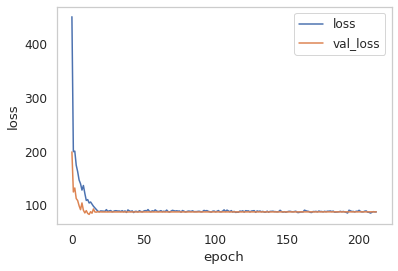

In [ ]:
import matplotlib.pyplot as plt
plt.grid(False)
ax.set_facecolor('white')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
pred = model.predict([x_test_multi])
print('Loss', model.evaluate(x_test_multi, [y_test_multi]))

Loss [54.14120126699473, 5.6916165]


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


### SHAP

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 24.8 MB/s 


In [ ]:
import shap

In [ ]:
shap.initjs()
explainer = shap.DeepExplainer(model, x_train_multi)
shap_values = explainer.shap_values(x_test_multi)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.



In [ ]:
#shap를 이용한 Feature importance
plt.grid(False)
ax.set_facecolor('white')
plt.ylabel('Variables', fontsize=13.5)
plt.title('(a) Feature importance of the urban area',
          position = (0.30, 1.02), fontsize=13.5)
shap.summary_plot(shap_values[23][:, 23, :], x_test_multi[:, 23, :], plot_type='bar', feature_names = train_x.columns)

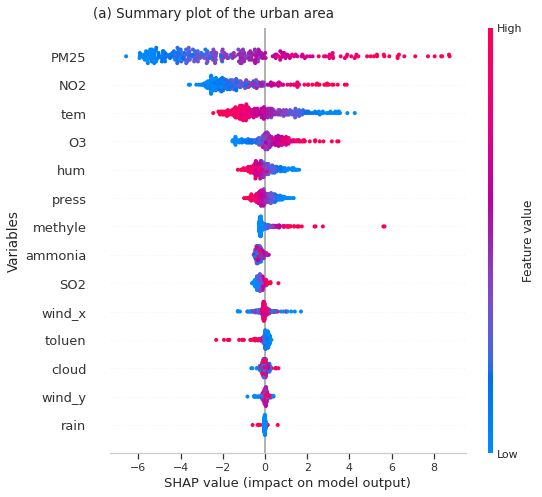

In [ ]:
#shap를 이용한 summary plot
plt.grid(False)
plt.ylabel('Variables', fontsize=13.5)
plt.title('(a) Summary plot of the urban area',
          position = (0.29, 1.01), fontsize=13.5)
shap.summary_plot(shap_values[23][:, 23, :], x_test_multi[:, 23, :], feature_names = train_x.columns)

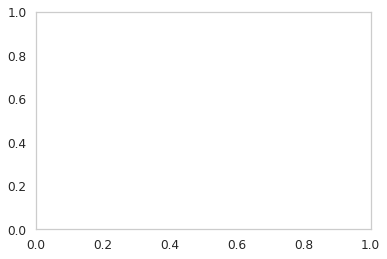

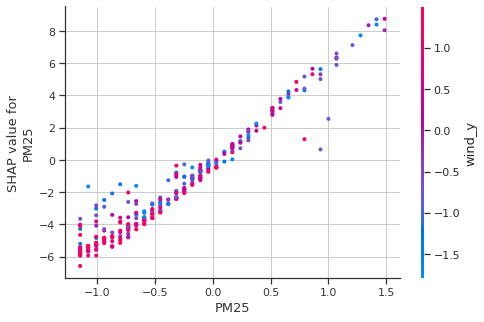

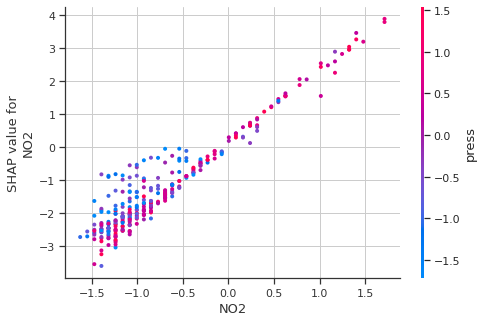

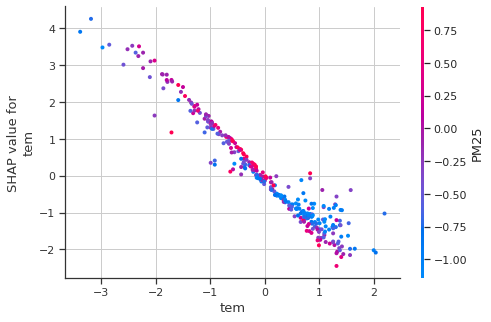

In [ ]:
plt.grid(False)
shap.initjs()
top_inds = np.argsort(-np.sum(np.abs(shap_values[23][:, 23, :]), 0))
plt.grid(False)
for i in range(3):
    shap.dependence_plot(top_inds[i], shap_values[23][:, 23, :], x_test_multi[:, 23, :], feature_names = train_x.columns)

In [ ]:
type(model)

keras.engine.sequential.Sequential

###  Dependence plot 원리

In [ ]:
#dependence plot이 그려지는 원리
def convert_names(ind, shap_values, input_names):
    if type(ind) == str:
        nzinds = np.where(np.array(input_names) == ind)[0]
        
nzinds = np.where(np.array(air_test.columns[1:]) == 'O3')[0]
nzinds[0]

1

In [ ]:
oinds = np.arange(shap_values[23][:, 23, :].shape[0])
np.random.shuffle(oinds)

In [ ]:
xv = x_test_multi[:, 23, :][oinds, 1].astype(np.float64)
xd = x_test_multi[:, 23, :][oinds, 1]
s = shap_values[23][:, 23, :][oinds, 1]

In [ ]:
x_test_multi[:, 23, :][oinds, 2].shape #2 = 'NO2'

(308,)

In [ ]:
air_test.date #23시간 마다 데이터 추출
test_date = []
for i in range(int(len(air_test.date)/24)):
    test_date.append(air_test.date[i*24])

In [ ]:
test_date = pd.DataFrame(test_date)[1:]
test_date = test_date.reset_index()
test_date = test_date.drop('index', axis=1)
test_date.head()

,0
0,2021-01-02 00:00:00
1,2021-01-03 00:00:00
2,2021-01-04 00:00:00
3,2021-01-05 00:00:00
4,2021-01-06 03:00:00


In [ ]:
test_date.shape, oinds.shape, xv.shape, s.shape

((308, 1), (308,), (308,), (308,))

In [ ]:
now_date = pd.DataFrame(test_shap_1[:, 23, :])[16]
new_date = pd.DataFrame(now_date[oinds])
new_date['xv'] = xv
new_date['s'] = s
new_date.head()

,16,xv,s
59,2021-03-09 18:00:00,0.926266,0.277595
230,2021-09-20 23:00:00,0.055380,-0.024513
69,2021-03-22 10:00:00,0.752089,0.178397
56,2021-03-06 14:00:00,0.403735,0.038842
152,2021-06-24 09:00:00,0.461794,0.022725


In [ ]:
#test_date['oinds'] = oinds
#test_date = test_date.sort_values(by='oinds')
#test_date = test_date.reset_index()
#test_date = test_date.drop('index', axis=1)
#test_date['xv'] = xv
#test_date['s'] = s
#test_date['new_date'] = new_date
#test_date.head()

In [ ]:
new_date.columns = ['date','xv','s']

In [ ]:
ax.get_xlim()

(-15.50492824296749, 10.524557352802173)

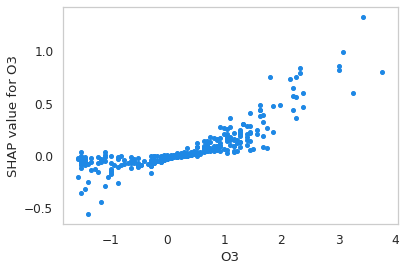

In [ ]:
plt.grid(False)
plt.xlabel('O3')
plt.ylabel('SHAP value for O3')
ax.axhline(0, color = '#888888', lw = 0.5, dashes=(1,5), zorder = -1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.scatter(new_date['xv'], new_date['s'], s=16, color = '#1E88E5', alpha=1, rasterized=len(xv) >500)

In [ ]:
#날짜 분석 (그래프가 두 가지로 나뉘는 이유)
#matplotlib아닌 plotly 이용
import plotly.graph_objects as go
import plotly.express as px
fig = px.scatter(new_date, x='xv', y='s', title='SHAP_dependence_plot(O3)', hover_data = ['date'], color = 's')
fig.update_layout(go.Layout(xaxis={'showgrid':False},yaxis={'showgrid':False}, paper_bgcolor='#FFFFFF', plot_bgcolor = '#FFFFFF'))
fig.show()

In [ ]:
shap.dependence_plot

<function shap.plots._scatter.dependence_legacy>

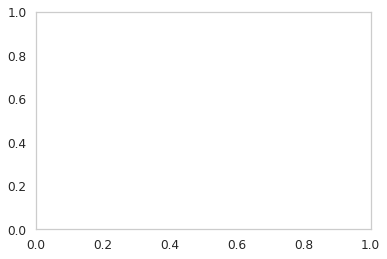

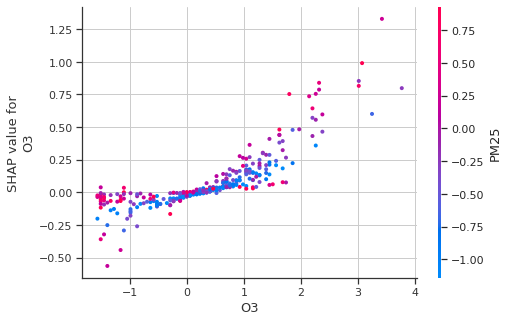

In [ ]:
plt.grid(False)
shap.dependence_plot('O3', shap_values[23][:, 23, :], x_test_multi[:, 23, :], interaction_index='PM25', feature_names = air_test.columns[1:])

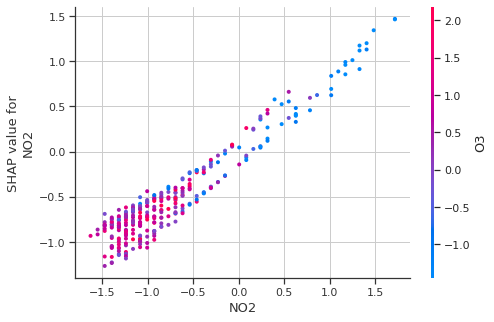

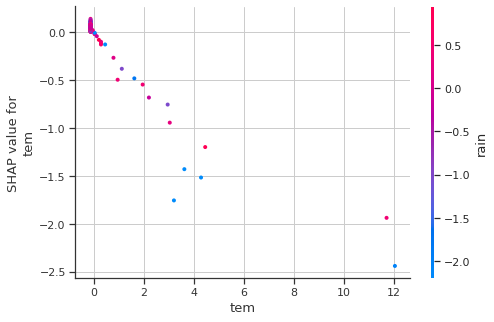

In [ ]:
shap.dependence_plot('NO2', shap_values[23][:, 23, :], x_test_multi[:, 23, :], interaction_index='O3', feature_names = air_test.columns[1:])
shap.dependence_plot('tem', shap_values[23][:, 23, :], x_test_multi[:, 23, :], interaction_index='rain', feature_names = air_test.columns[1:])

In [ ]:
shap_values[23][:, 23, :]

array([[-4.48841748e-01, -1.68689154e-02, -6.62719766e-01, ...,
        -1.52962767e-01,  2.76172659e-02, -1.60909514e-01],
       [-9.63422810e-01, -4.43532868e-03, -8.32298399e-01, ...,
        -1.52390620e-01,  3.17697324e-02, -1.62650056e-01],
       [-8.37370038e-01,  4.45945618e-03, -1.13147723e+00, ...,
        -1.48196998e-01,  4.73720746e-02, -1.50263246e-01],
       ...,
       [ 1.69629389e-01, -3.52373286e-02,  4.16177468e-01, ...,
        -1.33360343e-01,  1.73092586e-02,  1.62281969e-02],
       [-3.00829114e+00,  1.15251194e-03, -1.07300632e+00, ...,
        -1.48129515e-01,  3.09373480e-02, -1.43420588e-01],
       [-9.46614955e-01, -2.93862953e-02, -3.94193179e-01, ...,
        -1.49214992e-01, -7.41885743e-03, -1.60655840e-01]])

In [ ]:
shap.dependence_plot

<function shap.plots._scatter.dependence_legacy>

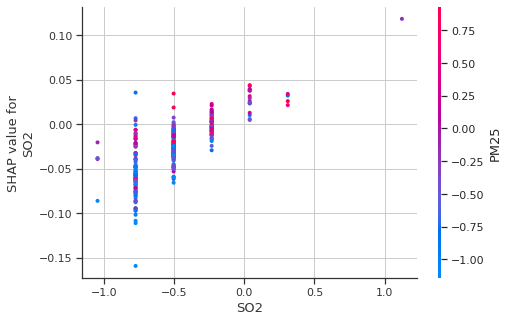

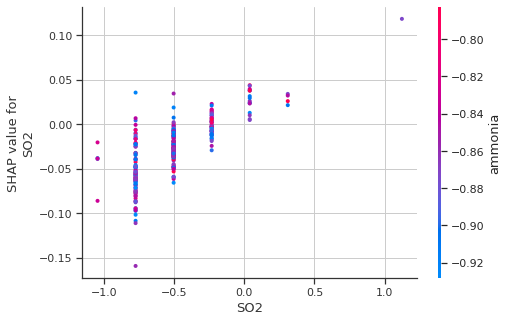

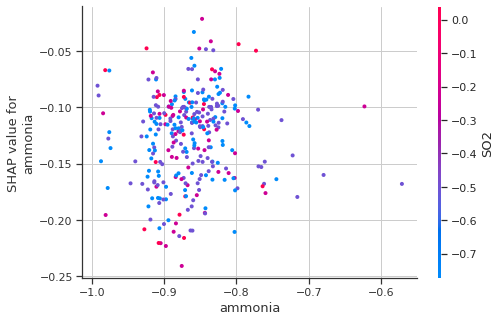

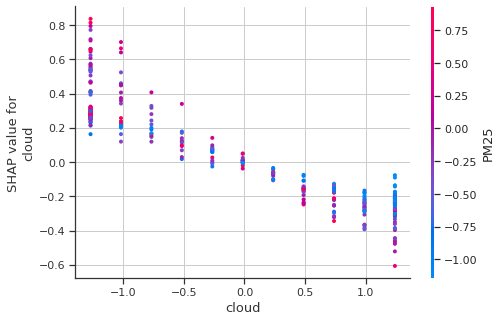

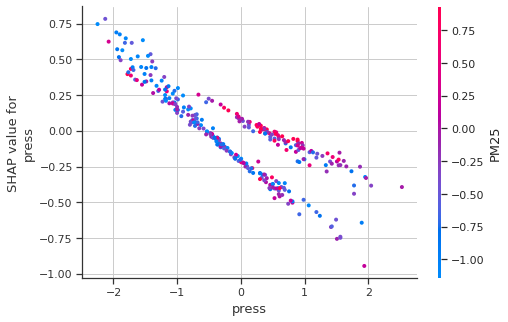

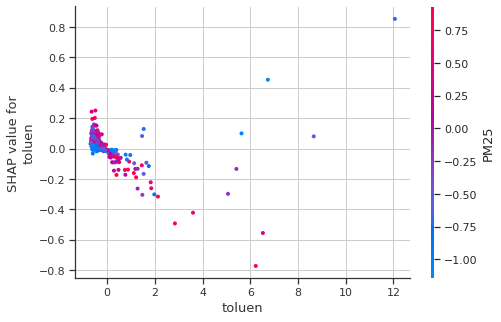

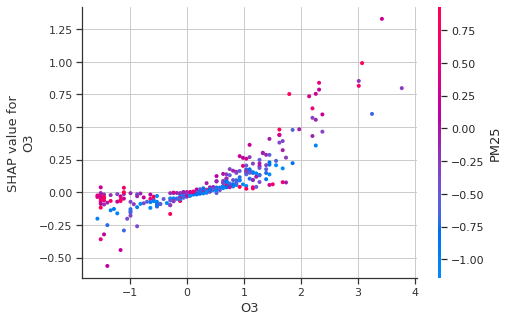

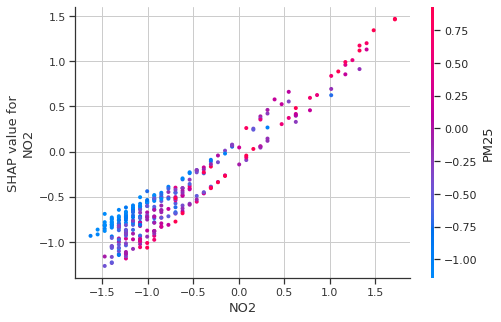

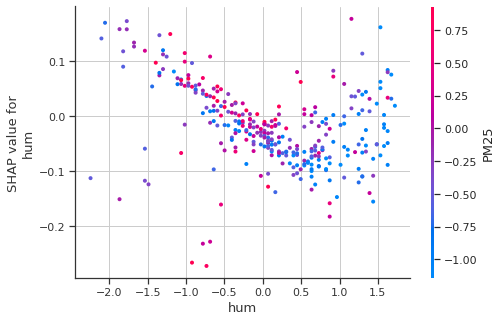

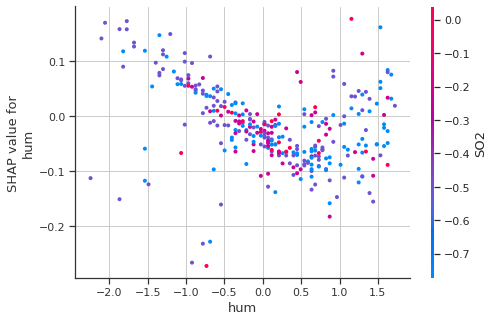

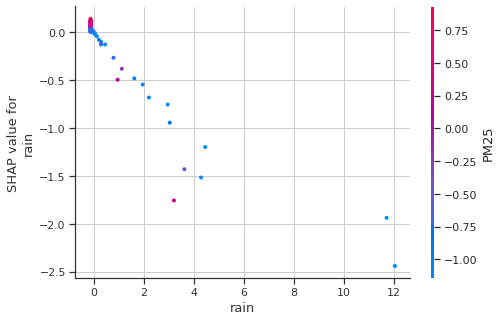

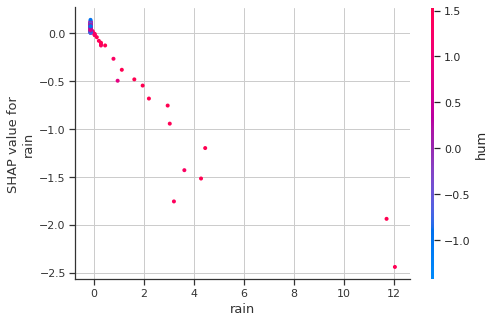

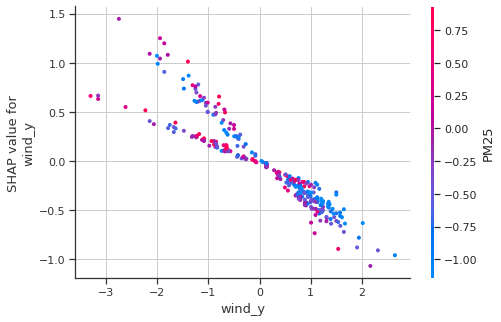

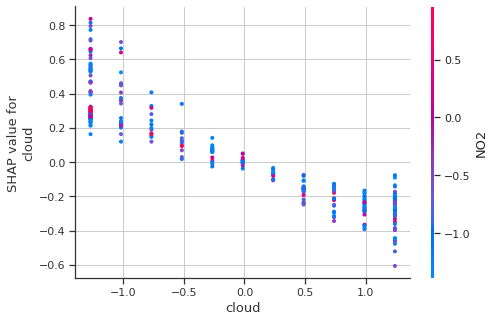

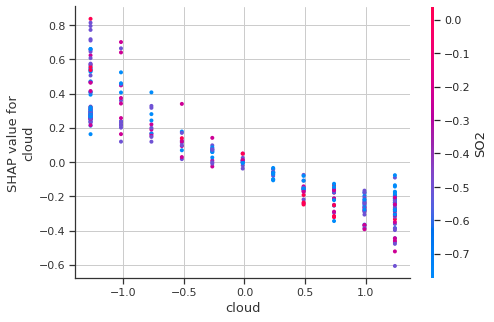

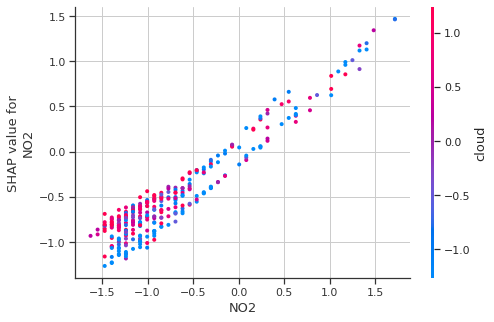

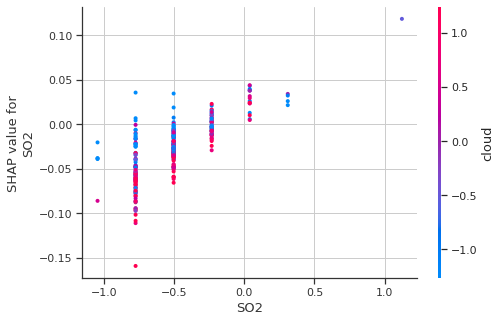

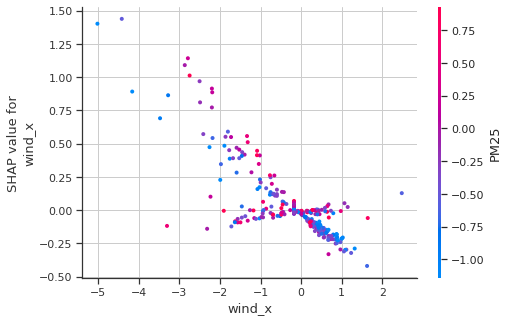

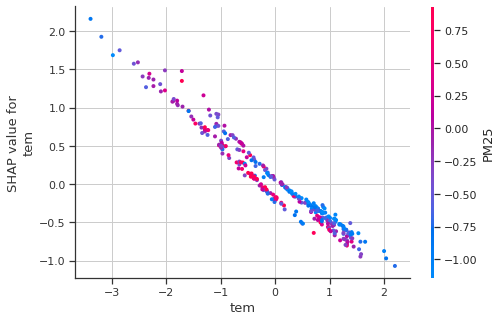

In [ ]:
shap.dependence_plot('SO2', shap_values[23][:, 23, :], x_test_multi[:, 23, :], interaction_index='PM25', feature_names = train_x.columns)
shap.dependence_plot('SO2', shap_values[23][:, 23, :], x_test_multi[:, 23, :], interaction_index='ammonia', feature_names = train_x.columns)
shap.dependence_plot('ammonia', shap_values[23][:, 23, :], x_test_multi[:, 23, :], interaction_index='SO2', feature_names = train_x.columns)
shap.dependence_plot('cloud', shap_values[23][:, 23, :], x_test_multi[:, 23, :], interaction_index='PM25', feature_names = train_x.columns)
shap.dependence_plot('press', shap_values[23][:, 23, :], x_test_multi[:, 23, :], interaction_index='PM25', feature_names = train_x.columns)
shap.dependence_plot('toluen', shap_values[23][:, 23, :], x_test_multi[:, 23, :], interaction_index='PM25', feature_names = train_x.columns)
shap.dependence_plot('O3', shap_values[23][:, 23, :], x_test_multi[:, 23, :], interaction_index='PM25', feature_names = train_x.columns)
shap.dependence_plot('NO2', shap_values[23][:, 23, :], x_test_multi[:, 23, :], interaction_index='PM25', feature_names = train_x.columns)
shap.dependence_plot('hum', shap_values[23][:, 23, :], x_test_multi[:, 23, :], interaction_index='PM25', feature_names = train_x.columns)
shap.dependence_plot('hum', shap_values[23][:, 23, :], x_test_multi[:, 23, :], interaction_index='SO2', feature_names = train_x.columns)
shap.dependence_plot('rain', shap_values[23][:, 23, :], x_test_multi[:, 23, :], interaction_index='PM25', feature_names = train_x.columns)
shap.dependence_plot('rain', shap_values[23][:, 23, :], x_test_multi[:, 23, :], interaction_index='hum', feature_names = train_x.columns)
shap.dependence_plot('wind_y', shap_values[23][:, 23, :], x_test_multi[:, 23, :], interaction_index='PM25', feature_names = train_x.columns)
shap.dependence_plot('cloud', shap_values[23][:, 23, :], x_test_multi[:, 23, :], interaction_index='NO2', feature_names = train_x.columns)
shap.dependence_plot('cloud', shap_values[23][:, 23, :], x_test_multi[:, 23, :], interaction_index='SO2', feature_names = train_x.columns)
shap.dependence_plot('NO2', shap_values[23][:, 23, :], x_test_multi[:, 23, :], interaction_index='cloud', feature_names = train_x.columns)
shap.dependence_plot('SO2', shap_values[23][:, 23, :], x_test_multi[:, 23, :], interaction_index='cloud', feature_names = train_x.columns)
shap.dependence_plot('wind_x', shap_values[23][:, 23, :], x_test_multi[:, 23, :], interaction_index='PM25', feature_names = train_x.columns)
shap.dependence_plot('tem', shap_values[23][:, 23, :], x_test_multi[:, 23, :], interaction_index='PM25', feature_names = train_x.columns)

#### SHAP code 분석 

In [ ]:
phis = []
for k in range(len(x_test_multi)):
    phis.append(np.zeros(x_test_multi[k].shape))
    
len(model.outputs)

1

In [ ]:
for j in range(x_test_multi[0].shape[0]):
    if (hasattr(x_train_multi, '__call__')):
        bg_data = x_train_multi([x_test_multi[l][j] for l in range(len(x_test_multi))])
        if type(bg_data) != list:
            bg_data = [bg_data]
    else:
            bg_data = x_train_multi
            
    tiled_X = [np.tile(x_test_multi[l][j:j+1], (bg_data[l].shape[0],)+ tuple([1 for k in range(len(x_test_multi[l].shape)-1)])) for l in range(len(x_test_multi))]
    joint_input = [np.concatenate([tiled_X[l], bg_data[l]], 0) for l in range(len(x_test_multi))]
    
hasattr(x_train_multi, '__call__')

False

In [ ]:
# model output
def __init__(self, model, data, session=None):
    def _get_model_output(self, model):
        if len(model.layers[-1]._inbound_nodes) ==0:
            if len(model.outputs) > 1:
                warnings.warn('Only one model output supported')
            return model.outputs[0]
        else:
            return model.layers[-1].output

In [ ]:
def shap_df(data):
    sh_value = []
    for i in range(len(data[23])):
        data = data
        s_value = pd.DataFrame(data[23][i])
        sh_value.append(s_value)
        s_values = pd.concat(sh_value, ignore_index=True)
    
    return s_values

In [ ]:
shap_df = shap_df(shap_values)

In [ ]:
shap_date = air_test.date[24:-21]
shap_date = shap_date.reset_index()
shap_df['date'] = shap_date['date']
shap_df = shap_df.set_index('date')

s_df = shap_df.reset_index()
s_df = s_df[s_df['date'].astype(str).str[11:13] == '23']
shap_values[23][:, 23, :]

array([[-0.96098939, -0.16592211, -0.97479928, ...,  0.331829  ,
         0.23756935, -0.13804585],
       [-1.63768403, -0.05265381, -1.24707282, ...,  0.33053938,
         0.40773873, -0.13671484],
       [-1.43786915,  0.04101461, -1.70090665, ...,  0.31072176,
         0.3733104 , -0.12916101],
       ...,
       [-0.12195828, -0.43390592,  0.7096289 , ...,  0.36107283,
         0.17362523,  0.01777853],
       [-4.37077999,  0.01671784, -1.57314092, ...,  0.309028  ,
         0.34167351, -0.11317638],
       [-1.64490032, -0.2265697 , -0.57778295, ...,  0.34291475,
         0.02232825, -0.1345671 ]])

In [ ]:
test_date = air_test.drop('tomm_pm', axis=1)
s_df.columns = test_date.columns
s_df = s_df.reset_index()
s_df = s_df.drop('index', axis=1)
s_df.head(2)

,date,PM25,O3,NO2,SO2,tem,rain,wind_x,wind_y,hum,press,cloud,ammonia,toluen,methyle
0,2021-01-02 23:00:00,-0.960989,-0.165922,-0.974799,-0.055930,1.535499,0.044124,-0.036688,-0.205036,-0.238518,-0.064993,0.421889,0.331829,0.237569,-0.138046
1,2021-01-03 23:00:00,-1.637684,-0.052654,-1.247073,-0.064977,1.818782,0.042421,0.019288,0.093290,-0.568770,0.020472,0.417336,0.330539,0.407739,-0.136715


In [ ]:
actual_no = pd.DataFrame(test_scaled['O3'])
actual_no['date'] = air_test['date']
actual_no = actual_no[24:-21]
actual_no = actual_no[actual_no['date'].astype(str).str[11:13] == '23']
actual_no = actual_no.reset_index()
actual_no = actual_no.drop('index', axis=1)

actual_no['shap_O3'] = s_df['O3']
print(len(shap_values[23][:, 23, 1].shape))
actual_no.head(2)

1


,O3,date,shap_O3
0,-0.176856,2021-01-02 23:00:00,-0.165922
1,0.287617,2021-01-03 23:00:00,-0.052654
